In [ ]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from hmpai.training import split_participants, split_participants_custom
from hmpai.pytorch.training import train_and_test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, load_model
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from hmpai.data import SAT_CLASSES_ACCURACY
from hmpai.pytorch.normalization import *
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.behaviour.sat2 import SAT2_SPLITS
from hmpai.visualization import predict_with_auc, set_seaborn_style, plot_peak_timing
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from pymer4.models import lmer, glmer
from scipy.stats import pearsonr
from prp_visu import *
import matplotlib.gridspec as gridspec
import polars as pl
from scipy.special import expit
from matplotlib.patches import Patch
import matplotlib.ticker as mtick
from tqdm.notebook import tqdm

DATA_PATH = Path(os.getenv("DATA_PATH"))

labels_t1 = ["negative", "t1_1", "t1_2", "t1_3"]
labels_t2 = ["negative", "t2_1", "t2_2", "t2_3"]
labels = ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"]
labels_cmb = labels_t1 + labels_t2[1:]
legible_labels = ["E1", "C1", "R1", "E2", "C2", "R2"]
# legible_labels = ["T1 Encoding", "T1 Central", "T1 Response", "T2 Encoding", "T2 Central", "T2 Response"]
# orders = [(0, 1, 2, 3, 4, 5), (0, 1, 3, 2, 4, 5), (0, 3, 1, 2, 4, 5), (0, 1, 3, 4, 2, 5), (0, 3, 1, 4, 2, 5), (0, 3, 4, 1, 2, 5)]
orders = [(0, 1, 2, 3, 4, 5), (0, 1, 3, 2, 4, 5), (0, 3, 1, 2, 4, 5), (0, 1, 3, 4, 2, 5), (0, 3, 1, 4, 2, 5), (0, 3, 4, 1, 2, 5)]

set_global_seed(42)
data_paths = [DATA_PATH / "prp/stage_data_250hz_t2.nc"]
splits = split_participants_custom(data_paths, 0.15)

# Old analysis

### Combined tasks

In [2]:
def determine_order(paths: list[Path], labels: list[list[str]]):
    df_t1 = pd.read_csv(paths[0])
    df_t2 = pd.read_csv(paths[1])
    # Combine dataframes on 'epoch' and 'participant'
    df = df_t1.merge(
        df_t2, on=["condition", "epoch", "participant"], suffixes=("_t1", "_t2")
    )
    labels_t1 = labels[0]
    labels_t2 = labels[1]
    pred_cols_t1 = [labels_t1[i] + "_pred" for i in range(1, len(labels_t1))]
    pred_cols_t2 = [labels_t2[i] + "_pred" for i in range(1, len(labels_t2))]

    # Add ISI to task 2 predictions to get absolute time
    df[pred_cols_t2] = df[pred_cols_t2].add(df["interval_t1"] * 250, axis=0)

    peak_order = df[pred_cols_t1 + pred_cols_t2].apply(lambda x: x.argsort(), axis=1)
    for i, col in enumerate(pred_cols_t1 + pred_cols_t2):
        df[f"event_{i}_idx"] = peak_order.iloc[:, i]

    return df

def determine_order_cmb(path):
    df = pd.read_csv(path)
    df_t1 = df[df["task"] == "prp1/t1"].copy()
    df_t2 = df[df["task"] == "prp1/t2"].copy()
    
    df_t1["correct_t1"] = df_t1["correct"]
    df_t2["correct_t2"] = df_t2["correct"]
    df_t1["rt_t1"] = df_t1["rt_samples"]
    df_t2["rt_t2"] = df_t2["rt_samples"]

    id_cols = ["participant", "epoch"]
    meta_cols = ["condition", "interval", "rt_t1", "rt_samples"]
    t1_cols = [col for col in df.columns if col.startswith("t1_")]
    t2_cols = [col for col in df.columns if col.startswith("t2_")]

    df_t1_reduced = df_t1[id_cols + meta_cols + ["correct_t1"] + t1_cols]
    df_t2_reduced = df_t2[id_cols + ["correct_t2", "rt_t2"] + t2_cols]

    df_merged_fixed = pd.merge(df_t1_reduced, df_t2_reduced, on=id_cols, how="inner")

    t1_pred_cols = [col for col in df_merged_fixed.columns if col.startswith("t1_") and col.endswith("_pred")]
    t2_pred_cols = [col for col in df_merged_fixed.columns if col.startswith("t2_") and col.endswith("_pred")]
    df_merged_fixed[t2_pred_cols] = df_merged_fixed[t2_pred_cols].add(df_merged_fixed["interval"] * 250, axis=0)

    peak_order = df_merged_fixed[t1_pred_cols + t2_pred_cols].apply(lambda x: x.argsort(), axis=1)
    for i, col in enumerate(t1_pred_cols + t2_pred_cols):
        df_merged_fixed[f"event_{i}_idx"] = peak_order.iloc[:, i]

    return df_merged_fixed

def remove_rare_orders(df: pd.DataFrame, labels: list[list[str]]):
    # Create a column with order tuples
    order_columns = [
        f"event_{i}_idx" for i in range(len(labels[0]) + len(labels[1]) - 2)
    ]
    df["order"] = df[order_columns].apply(tuple, axis=1)

    # Count number of (order, condition) pairs
    order_condition_counts = df.groupby(["order", "condition"]).size()
    print(order_condition_counts)
    # Calculate 1.5% threshold per condition
    condition_counts = df["condition"].value_counts()
    thresholds = condition_counts * 0.015

    # Keep only (order, condition) pairs above threshold
    valid_combinations = [
        (order, condition)
        for (order, condition), count in order_condition_counts.items()
        if count >= thresholds[condition]
    ]

    # Filter the DataFrame
    df = df[df.set_index(["order", "condition"]).index.isin(valid_combinations)]

    # Re-index orders
    # unique_orders = df["order"].unique()
    order_mapping = {order: idx for idx, order in enumerate(orders)}
    df["order_idx"] = df["order"].map(order_mapping)

    return df

In [3]:
df = pd.read_csv(Path("files/cmb_peaks.csv"))

In [3]:
df = determine_order_cmb(Path("files/cmb_peaks.csv"))
df = remove_rare_orders(df, [labels_t1, labels_t2])
df_no_val = df.copy()[~((df["condition"] == "long") & (df["participant"].isin(splits[0])))]

order               condition
(0, 1, 2, 3, 4, 5)  long         10918
                    short          711
(0, 1, 2, 4, 3, 5)  long             1
                    short            3
(0, 1, 3, 2, 4, 5)  long            75
                    short         5397
(0, 1, 3, 4, 2, 5)  long            12
                    short          653
(0, 1, 4, 3, 2, 5)  short            1
(0, 3, 1, 2, 4, 5)  long             1
                    short         2992
(0, 3, 1, 4, 2, 5)  long             3
                    short         1844
(0, 3, 1, 4, 5, 2)  short            4
(0, 3, 4, 1, 2, 5)  short          171
(0, 3, 4, 1, 5, 2)  short            2
(0, 3, 4, 5, 1, 2)  short            3
(1, 0, 2, 3, 4, 5)  long             1
(3, 0, 1, 4, 2, 5)  short            1
(3, 0, 4, 1, 2, 5)  short            1
dtype: int64


/tmp/ipykernel_1399859/2427589720.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["order_idx"] = df["order"].map(order_mapping)


In [8]:
df_no_val.groupby("condition")["rt_t1"].mean() / 250 * 1000

condition
long     611.070746
short    602.833147
Name: rt_t1, dtype: float64

### Visualization

In [12]:
def plot_sequence_bargraph(df, ax, labels):
    set_seaborn_style()
    order_counts = (
        df.groupby(["order_idx", "condition"])
          .size()
          .reset_index(name="count")
    )

    order_counts["prop"] = order_counts.groupby("condition")["count"].transform(lambda s: s / s.sum())

    # keep plotting order stable
    x_order   = sorted(order_counts["order_idx"].unique())
    hue_order = sorted(order_counts["condition"].unique())
    participant_col = 'participant'
    counts = (
        df.groupby([participant_col, "condition", "order_idx"])
          .size()
          .reset_index(name="n")
    )
    totals = (
        counts.groupby([participant_col, "condition"], as_index=False)["n"]
              .sum()
              .rename(columns={"n": "total"})
    )
    props = counts.merge(totals, on=[participant_col, "condition"], how="left")
    # guard against division by zero if someone has no trials in a condition
    props = props[props["total"] > 0].copy()
    props["prop"] = props["n"] / props["total"] * 100
    # draw split bars (temporary gray palette; we'll recolor after)
    g = sns.barplot(
        data=props, x="order_idx", y="prop",
        hue="condition", ax=ax,
        order=x_order, hue_order=hue_order,
        estimator="mean",
        errorbar=('ci', 95),
        err_kws={"color": "black", "linewidth": 1}, # https://matplotlib.org/stable/api/_as_gen/matplotlib.lines.Line2D.html#matplotlib.lines.Line2D
        n_boot=5000,
        palette=["#cccccc"] * len(hue_order),  # placeholder; we recolor beloww
    )
    
    # recolor bars by sequence (A,B,C,...)
    seq_palette = sns.color_palette()[5:10]  # pick your palette
    for patch, (seq, _cond) in zip(g.patches, order_counts[["order_idx", "condition"]].values):
        patch.set_facecolor(seq_palette[x_order.index(seq)])
    
    # add hatches by condition
    hatch_map = {hue_order[0]: "//", hue_order[1]: ""}  # e.g., long = hatched
    for patch, cond in zip(g.patches, order_counts["condition"].values):
        patch.set_hatch(hatch_map[cond])

    # condition legend (based on hatches)
    ax.legend_.remove()
    handles = [Patch(facecolor="0.85", edgecolor="black", hatch=hatch_map[c]) for c in hue_order]
    ax.legend(handles, hue_order, title="Condition")

    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_xlabel("Sequence")
    ax.set_ylabel("Trials (%)")
    ax.set_ylim(0, 100)

def plot_rt_bargraph(df, ax, labels, task="t1"):
    df, _ = get_rt_regression_df(df, task=task)
    # print(df)
    sns.barplot(data=df, x="sequence", y="mean", errorbar=None, ax=ax, hue="sequence", palette=sns.color_palette()[5:10])
    ax.errorbar(
        x=np.arange(len(df)),
        y=df["mean"],
        yerr=df["error"],
        fmt="none",
        ecolor="black",
        capsize=0
    )
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_xlabel("Sequence")
    ax.set_ylabel(f"Task {task[-1]} RT (in s)")
    ax.set_ylim(0, 1.0)

def get_rt_regression_df(df, task: str = "t1"):
    df = df.copy()
    df = df[df["condition"] == "short"]
    df[f"rt_{task}"] = df[f"rt_{task}"] / 250
    df = df[["participant", "order_idx", f"rt_{task}"]]
    df = df.dropna()
    df["participant"] = df["participant"].astype("category")
    df["order_idx"] = df["order_idx"].astype(str).astype("category")
    df = pl.from_dataframe(df)

    model = lmer(
        f"rt_{task} ~ order_idx + (1|participant)", data=df
    )
    model.set_factors({"order_idx": ["0", "1", "2", "3", "4"]})
    model.fit(verbose=False)
    result = get_rt_means_and_errors(model)
    return result, model

def get_rt_means_and_errors(model):
    df = model.result_fit.to_pandas()
    b0   = df.loc[df.term == "(Intercept)", "estimate"].iat[0]
    se0  = df.loc[df.term == "(Intercept)", "std_error"].iat[0]
    mask = df.term.str.startswith("order_idx")
    tmp  = df.loc[mask, ["term", "estimate", "std_error"]].copy()
    tmp["mean"]  = b0 + tmp["estimate"]
    tmp["se"]    = np.sqrt(se0**2 + tmp["std_error"]**2)   # approx: no covariance term
    tmp["error"] = 1.96 * tmp["se"]
    row0 = pd.DataFrame({
        "term":  ["order_idx0"],
        "mean":  [b0],
        "error": [1.96 * se0],
    })
    out = pd.concat([row0, tmp[["term", "mean", "error"]]], ignore_index=True)
    out.columns = ["sequence", "mean", "error"]
    return out

def plot_performance_bargraph(df, ax, labels, task="t1"):
    df, _ = get_performance_regression_df(df, task=task)
    sns.barplot(data=df, x="sequence", y="proba", errorbar=None, ax=ax, hue="sequence", legend=False, palette=sns.color_palette()[5:10])
    ax.errorbar(
        x=np.arange(len(df)),
        y=df["proba"],
        yerr=df["error"],
        fmt="none",
        ecolor="black",
        capsize=0
    )
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_xlabel("Sequence")
    ax.set_ylabel(f"Task {task[-1]} Accuracy")
    ax.set_ylim(0.6, 1.0)
    

def get_performance_regression_df(df, task="t1"):
    df = df.copy()
    df = df[df["condition"] == "short"]
    df = df[["participant", "order_idx", f"correct_{task}"]]
    df = df.dropna()
    df["participant"] = df["participant"].astype("category")
    df["order_idx"] = df["order_idx"].astype(str).astype("category")
    df = pl.from_dataframe(df)
    model = glmer(
        f"correct_{task} ~ order_idx + (1|participant)", data=df, family="binomial"
    )
    model.set_factors({"order_idx": ["0", "1", "2", "3", "4"]})
    model.fit(verbose=True)
    # print(model.summary())
    result = get_performance_means_and_errors(model)
    return result, model

def get_performance_means_and_errors(model):
    df = model.result_fit.to_pandas()
    intercept = df.loc[df.term == "(Intercept)", "estimate"].iat[0]
    intercept_low = df.loc[df.term == "(Intercept)", "conf_low"].iat[0]
    intercept_high = df.loc[df.term == "(Intercept)", "conf_high"].iat[0]

    probs = []
    probs.append({"sequence": 0, "proba": expit(intercept), "error": (expit(intercept_high) - expit(intercept_low)) / 2})

    for _, row in df.iterrows():
        if not row['term'].startswith('order_idx'):
            continue
        order_idx = row['term'].split("x")[-1]
        proba = expit(intercept + row["estimate"])
        err = (expit(intercept_high + row["conf_high"]) - expit(intercept_low + row["conf_low"])) / 2
        probs.append({"sequence": order_idx, "proba": proba, "error": err})
    return pd.DataFrame(probs)


In [10]:
def plot_all(df):
    sequence_labels = ["A","B","C","D","E"]
    set_seaborn_style()
    fig = plt.figure(figsize=(7.09, 4.2), dpi=300, constrained_layout=True)
    gs  = gridspec.GridSpec(
        2, 9, figure=fig,
        width_ratios=[1,1,1, 1,1,1, 1,1,1], height_ratios=[1,1]
    )

    ax_a = fig.add_subplot(gs[0, 0:3])
    plot_sequence_bargraph(df, ax_a, sequence_labels)

    ax_b = fig.add_subplot(gs[0, 3:6])
    plot_rt_bargraph(df, ax_b, sequence_labels)

    ax_c = fig.add_subplot(gs[0, 6:9])
    plot_performance_bargraph(df, ax_c, sequence_labels)

    ax_d = fig.add_subplot(gs[1, 0:8])
    plot_sequences_per_participant(df, sequence_labels, ax_d)
    
    handles, _ = ax_d.get_legend_handles_labels()
    ax_d.legend().remove()
    fig.legend(handles[::-1], sequence_labels, title="Sequence",
               loc="center left", bbox_to_anchor=(0.885, 0.3))
    
    fig.text(0.005, 0.98, "a)", fontweight="bold")
    fig.text(0.35, 0.98, "b)", fontweight="bold")
    fig.text(0.69, 0.98, "c)", fontweight="bold")
    fig.text(0.005, 0.48, "d)", fontweight="bold")
    plt.savefig("../img/sequences_result.pdf", transparent=True, bbox_inches="tight")
    plt.show()

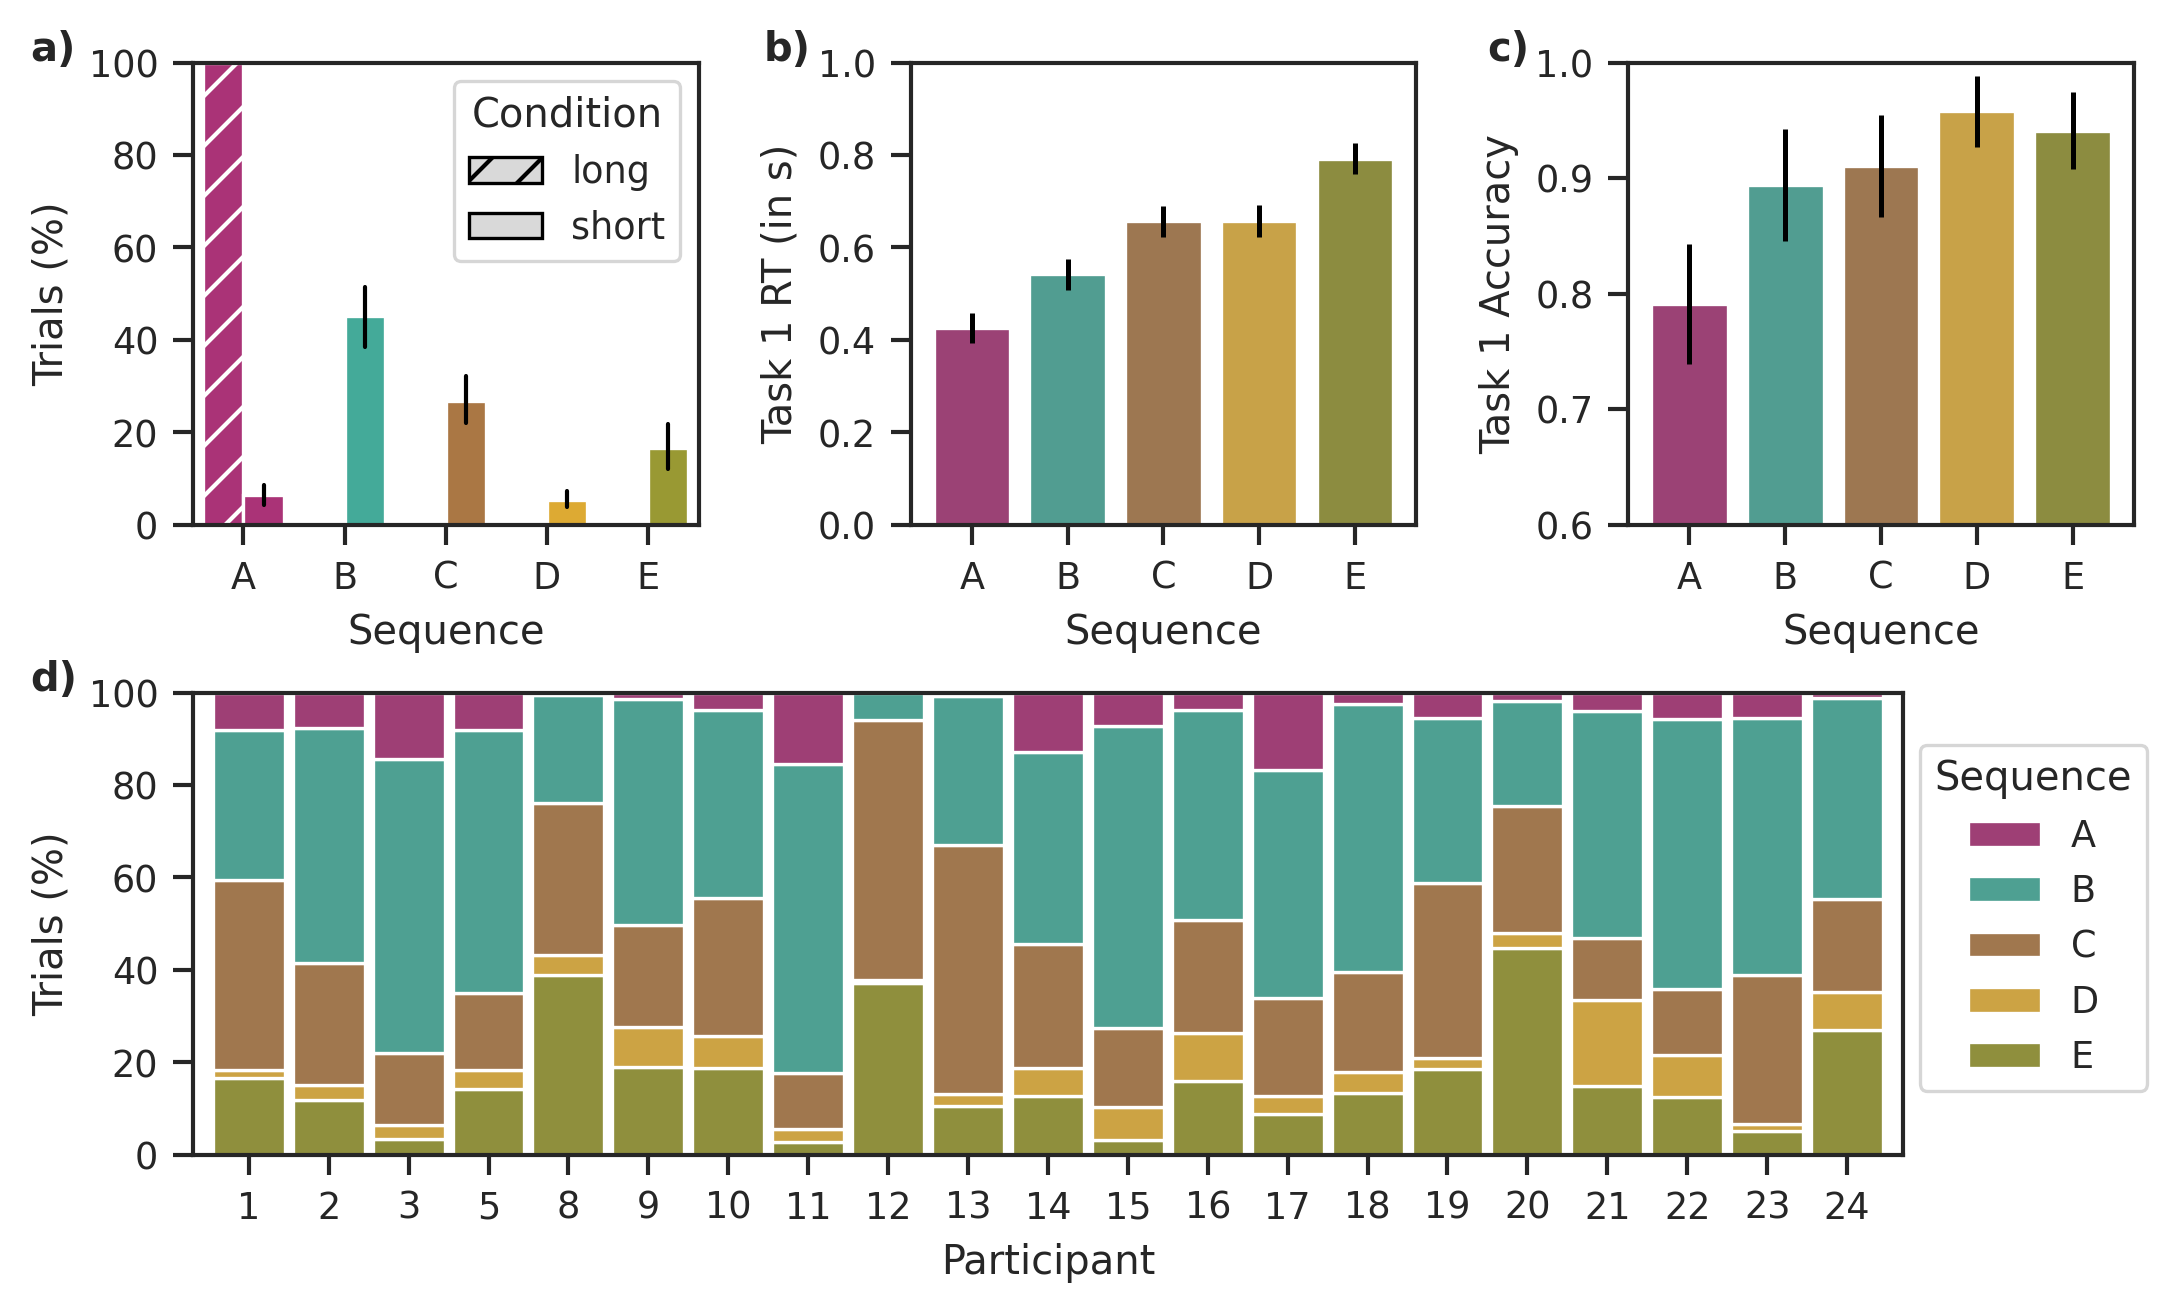

In [11]:
plot_all(df_no_val)

### Stats

#### T1

In [13]:
_, rt_model = get_rt_regression_df(df_no_val)

In [14]:
rt_model.summary()

GT(_tbl_data=shape: (9, 10)
┌─────────────┬─────────────┬──────────┬───────────┬───┬───────────┬─────────────┬─────────┬───────┐
│ rfx         ┆ param       ┆ estimate ┆ std_error ┆ … ┆ t_stat    ┆ df          ┆ p_value ┆ stars │
│ ---         ┆ ---         ┆ ---      ┆ ---       ┆   ┆ ---       ┆ ---         ┆ ---     ┆ ---   │
│ str         ┆ str         ┆ f64      ┆ f64       ┆   ┆ f64       ┆ f64         ┆ str     ┆ str   │
╞═════════════╪═════════════╪══════════╪═══════════╪═══╪═══════════╪═════════════╪═════════╪═══════╡
│ participant ┆ (Intercept) ┆ 0.071723 ┆ null      ┆ … ┆ null      ┆ null        ┆ null    ┆ null  │
│ -sd         ┆             ┆          ┆           ┆   ┆           ┆             ┆         ┆       │
│ Residual-sd ┆ Observation ┆ 0.127509 ┆ null      ┆ … ┆ null      ┆ null        ┆ null    ┆ null  │
│ null        ┆ null        ┆ null     ┆ null      ┆ … ┆ null      ┆ null        ┆ null    ┆ null  │
│ Fixed       ┆ null        ┆ null     ┆ null      ┆ … ┆ null      ┆ null        ┆ null    ┆ null  │
│ Effects:    ┆             ┆          ┆           ┆   ┆           ┆             ┆         ┆       │
│ null        ┆ (Intercept) ┆ 0.42536  ┆ 0.016398  ┆ … ┆ 25.940418 ┆ 23.699486   ┆ <.001   ┆ ***   │
│ null        ┆ order_idx1  ┆ 0.116633 ┆ 0.005153  ┆ … ┆ 22.636208 ┆ 11575.41494 ┆ <.001   ┆ ***   │
│             ┆             ┆          ┆           ┆   ┆           ┆ 7           ┆         ┆       │
│ null        ┆ order_idx2  ┆ 0.230854 ┆ 0.005481  ┆ … ┆ 42.120672 ┆ 11580.33211 ┆         ┆ ***   │
│             ┆             ┆          ┆           ┆   ┆           ┆ 2           ┆         ┆       │
│ null        ┆ order_idx3  ┆ 0.232055 ┆ 0.007059  ┆ … ┆ 32.87366  ┆ 11577.26156 ┆ <.001   ┆ ***   │
│             ┆             ┆          ┆           ┆   ┆           ┆ 4           ┆         ┆       │
│ null        ┆ order_idx4  ┆ 0.366527 ┆ 0.005869  ┆ … ┆ 62.453426 ┆ 11583.03994 ┆         ┆ ***   │
│             ┆             ┆          ┆           ┆   ┆           ┆ 3           ┆         ┆       │
└─────────────┴─────────────┴──────────┴───────────┴───┴───────────┴─────────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7ff51a22f990>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', type=<ColInfoTypeEnum.default: 1>, column_label='T-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='DF', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7ff50b7e8210>, _spanners=Spanners([]), _heading=Heading(title='Formula: lmer(rt_t1~order_idx+(1|participant))', subtitle=Md(text='Number of observations: *11597*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            Log-likelihood: *7356*  \n            AIC: *-14698* | BIC: *-14646*  \n            Residual error: *0.128*  \n        '), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _style

In [31]:
rt_model.anova(summary=True)

GT(_tbl_data=shape: (1, 7)
┌────────────┬─────┬─────┬──────────┬─────────┬─────────┬───────┐
│ model term ┆ df1 ┆ df2 ┆ F_ratio  ┆ Chisq   ┆ p_value ┆ stars │
│ ---        ┆ --- ┆ --- ┆ ---      ┆ ---     ┆ ---     ┆ ---   │
│ str        ┆ f64 ┆ f64 ┆ f64      ┆ f64     ┆ str     ┆ str   │
╞════════════╪═════╪═════╪══════════╪═════════╪═════════╪═══════╡
│ order_idx  ┆ 4.0 ┆ inf ┆ 1573.095 ┆ 6292.38 ┆         ┆ ***   │
└────────────┴─────┴─────┴──────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7f99e4539410>, _boxhead=Boxhead([ColInfo(var='model term', type=<ColInfoTypeEnum.default: 1>, column_label='model term', column_align='left', column_width=None), ColInfo(var='df1', type=<ColInfoTypeEnum.default: 1>, column_label='df1', column_align='right', column_width=None), ColInfo(var='df2', type=<ColInfoTypeEnum.default: 1>, column_label='df2', column_align='right', column_width=None), ColInfo(var='F_ratio', type=<ColInfoTypeEnum.default: 1>, column_label='F_ratio', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p_value', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7f9a08fb6710>, _spanners=Spanners([]), _heading=Heading(title='ANOVA (Type III tests)', subtitle=None, preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7f9a08f6b690>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7f99e4515590>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=Tru

In [21]:
rt_model.emmeans('order_idx', contrasts='pairwise', p_adjust='holm')

contrast,estimate,SE,df,asymp_LCL,asymp_UCL,z_ratio,p_value
str,f64,f64,f64,f64,f64,f64,f64
"""order_idx0 - order_idx1""",-0.116633,0.005153,inf,-0.131097,-0.10217,-22.636208,5.7229e-113
"""order_idx0 - order_idx2""",-0.230854,0.005481,inf,-0.246239,-0.215469,-42.120672,0.0
"""order_idx0 - order_idx3""",-0.232055,0.007059,inf,-0.25187,-0.212241,-32.87366,2.6153e-236
"""order_idx0 - order_idx4""",-0.366527,0.005869,inf,-0.383001,-0.350053,-62.453426,0.0
"""order_idx1 - order_idx2""",-0.11422,0.003035,inf,-0.122739,-0.105702,-37.637381,0.0
"""order_idx1 - order_idx3""",-0.115422,0.005357,inf,-0.130459,-0.100385,-21.546141,1.1510e-102
"""order_idx1 - order_idx4""",-0.249894,0.003637,inf,-0.260103,-0.239684,-68.70762,0.0
"""order_idx2 - order_idx3""",-0.001202,0.005644,inf,-0.017044,0.014641,-0.212887,0.831415
"""order_idx2 - order_idx4""",-0.135673,0.003861,inf,-0.146512,-0.124834,-35.135726,1.1523e-269


In [ ]:
_, perf_model = get_performance_regression_df(df_no_val)

In [32]:
perf_model.anova(summary=True)

GT(_tbl_data=shape: (1, 7)
┌────────────┬─────┬─────┬─────────┬────────┬─────────┬───────┐
│ model term ┆ df1 ┆ df2 ┆ F_ratio ┆ Chisq  ┆ p_value ┆ stars │
│ ---        ┆ --- ┆ --- ┆ ---     ┆ ---    ┆ ---     ┆ ---   │
│ str        ┆ f64 ┆ f64 ┆ f64     ┆ f64    ┆ str     ┆ str   │
╞════════════╪═════╪═════╪═════════╪════════╪═════════╪═══════╡
│ order_idx  ┆ 4.0 ┆ inf ┆ 37.535  ┆ 150.14 ┆ <.001   ┆ ***   │
└────────────┴─────┴─────┴─────────┴────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7f9a0a3dbf10>, _boxhead=Boxhead([ColInfo(var='model term', type=<ColInfoTypeEnum.default: 1>, column_label='model term', column_align='left', column_width=None), ColInfo(var='df1', type=<ColInfoTypeEnum.default: 1>, column_label='df1', column_align='right', column_width=None), ColInfo(var='df2', type=<ColInfoTypeEnum.default: 1>, column_label='df2', column_align='right', column_width=None), ColInfo(var='F_ratio', type=<ColInfoTypeEnum.default: 1>, column_label='F_ratio', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p_value', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7f9a0a302050>, _spanners=Spanners([]), _heading=Heading(title='ANOVA (Type III tests)', subtitle=None, preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7f99e452c110>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7f99e4515f10>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_bord

In [22]:
perf_model.emmeans('order_idx', contrasts='pairwise', p_adjust='holm')

contrast,odds_ratio,SE,df,asymp_LCL,asymp_UCL,null,z_ratio,p_value
cat,f64,f64,f64,f64,f64,f64,f64,f64
"""order_idx0 / order_idx1""",0.447688,0.043752,inf,0.340279,0.589,1.0,-8.223293,1.3859e-15
"""order_idx0 / order_idx2""",0.371811,0.041373,inf,0.272064,0.508128,1.0,-8.891348,5.4335e-18
"""order_idx0 / order_idx3""",0.166334,0.034405,inf,0.093072,0.297263,1.0,-8.672018,3.3962e-17
"""order_idx0 / order_idx4""",0.237099,0.032458,inf,0.161451,0.348191,1.0,-10.513567,7.4809e-25
"""order_idx1 / order_idx2""",0.830513,0.065086,inf,0.666513,1.034865,1.0,-2.369724,0.035603
"""order_idx1 / order_idx3""",0.371539,0.070805,inf,0.217612,0.634346,1.0,-5.195433,0.000001
"""order_idx1 / order_idx4""",0.529607,0.058501,inf,0.388412,0.722131,1.0,-5.754193,5.2234e-8
"""order_idx2 / order_idx3""",0.447361,0.088369,inf,0.25695,0.778875,1.0,-4.072154,0.000186
"""order_idx2 / order_idx4""",0.637687,0.075863,inf,0.456646,0.890504,1.0,-3.781836,0.000467


#### T2

In [50]:
def plot_t2(df):
    sequence_labels = ["A","B","C","D","E"]
    set_seaborn_style()
    fig, ax = plt.subplots(1, 2, figsize=(7.09, 2.1), dpi=300, constrained_layout=True)

    plot_rt_bargraph(df, ax[0], sequence_labels, task="t2")

    plot_performance_bargraph(df, ax[1], sequence_labels, task="t2")
    
    
    fig.text(0.005, 0.98, "a)", fontweight="bold")
    fig.text(0.55, 0.98, "b)", fontweight="bold")
    # plt.savefig("../img/sequences_result.pdf", transparent=True, bbox_inches="tight")
    plt.show()

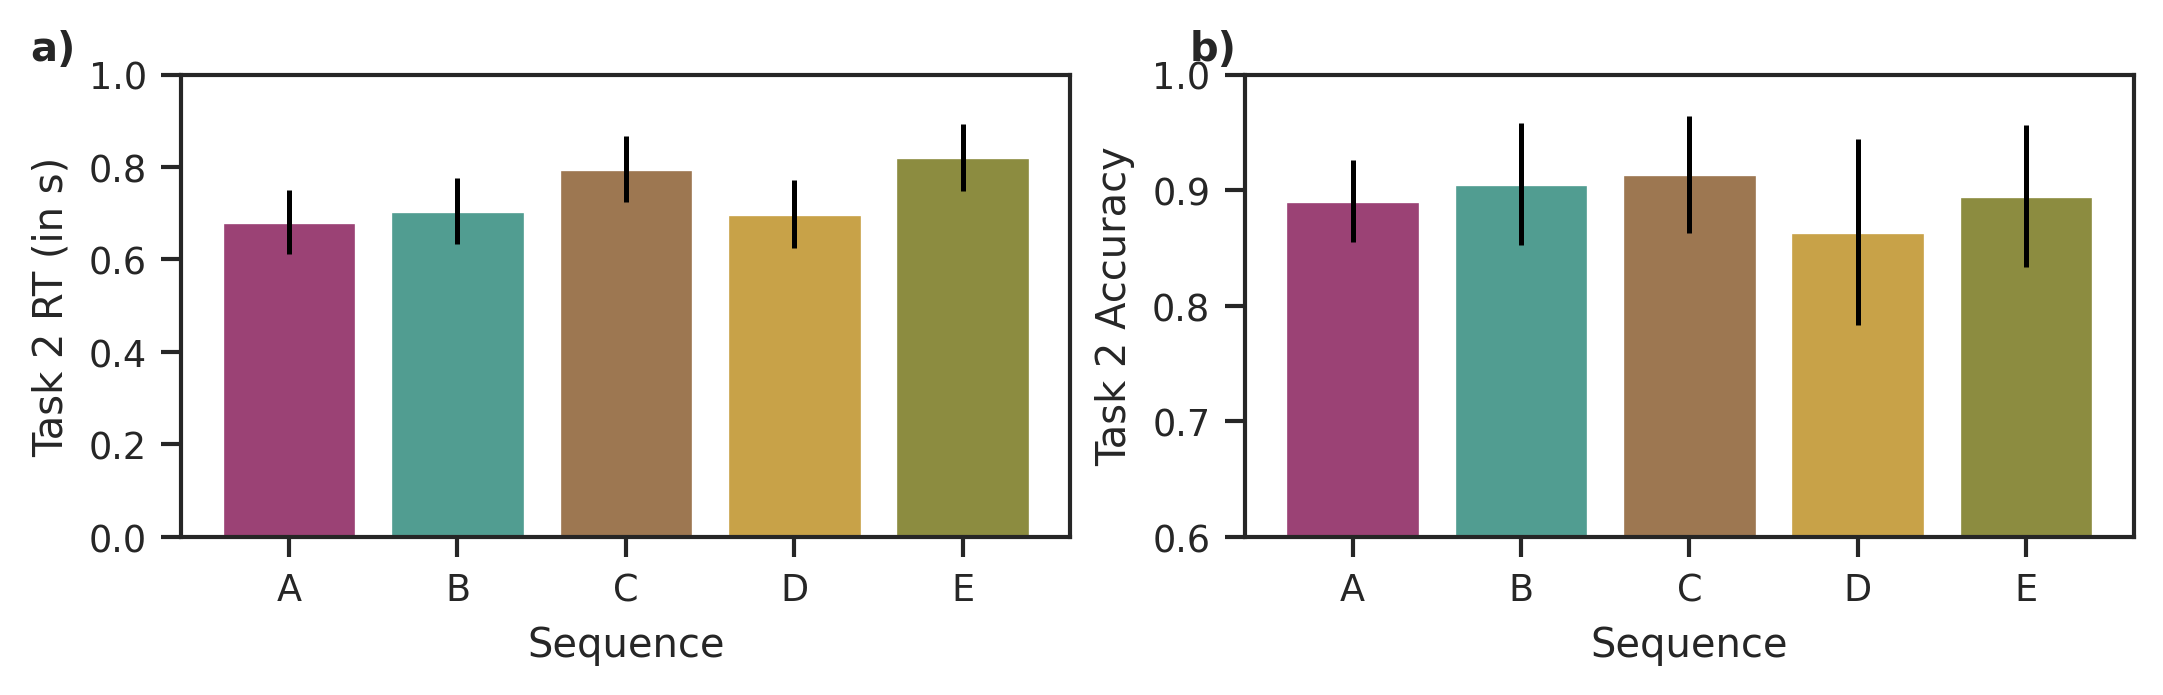

In [53]:
plot_t2(df_no_val)

In [36]:
_, rt_model = get_rt_regression_df(df_no_val, task="t2")

In [38]:
rt_model.summary()

GT(_tbl_data=shape: (9, 10)
┌─────────────┬─────────────┬──────────┬───────────┬───┬───────────┬────────────┬──────────┬───────┐
│ rfx         ┆ param       ┆ estimate ┆ std_error ┆ … ┆ t_stat    ┆ df         ┆ p_value  ┆ stars │
│ ---         ┆ ---         ┆ ---      ┆ ---       ┆   ┆ ---       ┆ ---        ┆ ---      ┆ ---   │
│ str         ┆ str         ┆ f64      ┆ f64       ┆   ┆ f64       ┆ f64        ┆ str      ┆ str   │
╞═════════════╪═════════════╪══════════╪═══════════╪═══╪═══════════╪════════════╪══════════╪═══════╡
│ participant ┆ (Intercept) ┆ 0.157922 ┆ null      ┆ … ┆ null      ┆ null       ┆ null     ┆ null  │
│ -sd         ┆             ┆          ┆           ┆   ┆           ┆            ┆          ┆       │
│ Residual-sd ┆ Observation ┆ 0.205462 ┆ null      ┆ … ┆ null      ┆ null       ┆ null     ┆ null  │
│ null        ┆ null        ┆ null     ┆ null      ┆ … ┆ null      ┆ null       ┆ null     ┆ null  │
│ Fixed       ┆ null        ┆ null     ┆ null      ┆ … ┆ null      ┆ null       ┆ null     ┆ null  │
│ Effects:    ┆             ┆          ┆           ┆   ┆           ┆            ┆          ┆       │
│ null        ┆ (Intercept) ┆ 0.679968 ┆ 0.035351  ┆ … ┆ 19.234615 ┆ 21.969304  ┆ <.001    ┆ ***   │
│ null        ┆ order_idx1  ┆ 0.024673 ┆ 0.008303  ┆ … ┆ 2.971652  ┆ 11573.8877 ┆ 0.002968 ┆ **    │
│             ┆             ┆          ┆           ┆   ┆           ┆ 67         ┆          ┆       │
│ null        ┆ order_idx2  ┆ 0.116253 ┆ 0.008832  ┆ … ┆ 13.162318 ┆ 11576.7651 ┆ <.001    ┆ ***   │
│             ┆             ┆          ┆           ┆   ┆           ┆ 61         ┆          ┆       │
│ null        ┆ order_idx3  ┆ 0.018547 ┆ 0.011375  ┆ … ┆ 1.630464  ┆ 11574.9365 ┆ 0.103    ┆       │
│             ┆             ┆          ┆           ┆   ┆           ┆ 34         ┆          ┆       │
│ null        ┆ order_idx4  ┆ 0.140593 ┆ 0.009458  ┆ … ┆ 14.865041 ┆ 11578.4829 ┆ <.001    ┆ ***   │
│             ┆             ┆          ┆           ┆   ┆           ┆ 87         ┆          ┆       │
└─────────────┴─────────────┴──────────┴───────────┴───┴───────────┴────────────┴──────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7f9a4d4a8610>, _boxhead=Boxhead([ColInfo(var='rfx', type=<ColInfoTypeEnum.default: 1>, column_label='Random Effects:', column_align='left', column_width=None), ColInfo(var='param', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None), ColInfo(var='estimate', type=<ColInfoTypeEnum.default: 1>, column_label='Estimate', column_align='right', column_width=None), ColInfo(var='std_error', type=<ColInfoTypeEnum.default: 1>, column_label='SE', column_align='right', column_width=None), ColInfo(var='conf_low', type=<ColInfoTypeEnum.default: 1>, column_label='CI-low', column_align='right', column_width=None), ColInfo(var='conf_high', type=<ColInfoTypeEnum.default: 1>, column_label='CI-high', column_align='right', column_width=None), ColInfo(var='t_stat', type=<ColInfoTypeEnum.default: 1>, column_label='T-stat', column_align='right', column_width=None), ColInfo(var='df', type=<ColInfoTypeEnum.default: 1>, column_label='DF', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7f99e451f910>, _spanners=Spanners([]), _heading=Heading(title='Formula: lmer(rt_t2~order_idx+(1|participant))', subtitle=Md(text='Number of observations: *11597*  \n            Confidence intervals: *parametric*  \n            ---------------------  \n            Log-likelihood: *1819*  \n            AIC: *-3625* | BIC: *-3573*  \n            Residual error: *0.205*  \n        '), preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=

In [37]:
rt_model.anova(summary=True)

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 11597' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 11597)' or larger];
but be warned that this may result in large computation time and memory use.

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 11597' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 11597)' or larger];
but be warned that this may result in large computation time and memory use.



GT(_tbl_data=shape: (1, 7)
┌────────────┬─────┬─────┬─────────┬─────────┬─────────┬───────┐
│ model term ┆ df1 ┆ df2 ┆ F_ratio ┆ Chisq   ┆ p_value ┆ stars │
│ ---        ┆ --- ┆ --- ┆ ---     ┆ ---     ┆ ---     ┆ ---   │
│ str        ┆ f64 ┆ f64 ┆ f64     ┆ f64     ┆ str     ┆ str   │
╞════════════╪═════╪═════╪═════════╪═════════╪═════════╪═══════╡
│ order_idx  ┆ 4.0 ┆ inf ┆ 161.172 ┆ 644.688 ┆ <.001   ┆ ***   │
└────────────┴─────┴─────┴─────────┴─────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7f9a4cccfb90>, _boxhead=Boxhead([ColInfo(var='model term', type=<ColInfoTypeEnum.default: 1>, column_label='model term', column_align='left', column_width=None), ColInfo(var='df1', type=<ColInfoTypeEnum.default: 1>, column_label='df1', column_align='right', column_width=None), ColInfo(var='df2', type=<ColInfoTypeEnum.default: 1>, column_label='df2', column_align='right', column_width=None), ColInfo(var='F_ratio', type=<ColInfoTypeEnum.default: 1>, column_label='F_ratio', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p_value', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7f99b87951d0>, _spanners=Spanners([]), _heading=Heading(title='ANOVA (Type III tests)', subtitle=None, preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7f99e451fe50>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7f99e458a910>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), tab

In [39]:
rt_model.emmeans('order_idx', contrasts='pairwise', p_adjust='holm')

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 11597' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 11597)' or larger];
but be warned that this may result in large computation time and memory use.

R messages: 
Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 11597' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 11597)' or larger];
but be warned that this may result in large computation time and memory use.



contrast,estimate,SE,df,asymp_LCL,asymp_UCL,z_ratio,p_value
str,f64,f64,f64,f64,f64,f64,f64
"""order_idx0 - order_idx1""",-0.024673,0.008303,inf,-0.047979,-0.001367,-2.971652,0.008886
"""order_idx0 - order_idx2""",-0.116253,0.008832,inf,-0.141046,-0.091461,-13.162318,1.0121e-38
"""order_idx0 - order_idx3""",-0.018547,0.011375,inf,-0.050477,0.013384,-1.630464,0.206007
"""order_idx0 - order_idx4""",-0.140593,0.009458,inf,-0.167142,-0.114044,-14.865041,4.4465e-49
"""order_idx1 - order_idx2""",-0.09158,0.004891,inf,-0.105309,-0.077852,-18.725103,2.7816e-77
"""order_idx1 - order_idx3""",0.006126,0.008632,inf,-0.018105,0.030357,0.709691,0.477896
"""order_idx1 - order_idx4""",-0.11592,0.005862,inf,-0.132374,-0.099466,-19.775966,4.7955e-86
"""order_idx2 - order_idx3""",0.097707,0.009095,inf,0.072177,0.123236,10.743019,3.1960e-26
"""order_idx2 - order_idx4""",-0.02434,0.006222,inf,-0.041806,-0.006873,-3.911559,0.000367


In [40]:
_, perf_model = get_performance_regression_df(df_no_val, task="t2")

In [41]:
perf_model.anova(summary=True)

GT(_tbl_data=shape: (1, 7)
┌────────────┬─────┬─────┬─────────┬────────┬─────────┬───────┐
│ model term ┆ df1 ┆ df2 ┆ F_ratio ┆ Chisq  ┆ p_value ┆ stars │
│ ---        ┆ --- ┆ --- ┆ ---     ┆ ---    ┆ ---     ┆ ---   │
│ str        ┆ f64 ┆ f64 ┆ f64     ┆ f64    ┆ str     ┆ str   │
╞════════════╪═════╪═════╪═════════╪════════╪═════════╪═══════╡
│ order_idx  ┆ 4.0 ┆ inf ┆ 4.733   ┆ 18.932 ┆ <.001   ┆ ***   │
└────────────┴─────┴─────┴─────────┴────────┴─────────┴───────┘, _body=<great_tables._gt_data.Body object at 0x7f99e4588550>, _boxhead=Boxhead([ColInfo(var='model term', type=<ColInfoTypeEnum.default: 1>, column_label='model term', column_align='left', column_width=None), ColInfo(var='df1', type=<ColInfoTypeEnum.default: 1>, column_label='df1', column_align='right', column_width=None), ColInfo(var='df2', type=<ColInfoTypeEnum.default: 1>, column_label='df2', column_align='right', column_width=None), ColInfo(var='F_ratio', type=<ColInfoTypeEnum.default: 1>, column_label='F_ratio', column_align='right', column_width=None), ColInfo(var='Chisq', type=<ColInfoTypeEnum.default: 1>, column_label='Chisq', column_align='right', column_width=None), ColInfo(var='p_value', type=<ColInfoTypeEnum.default: 1>, column_label='p_value', column_align='left', column_width=None), ColInfo(var='stars', type=<ColInfoTypeEnum.default: 1>, column_label='', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7f99b87cd110>, _spanners=Spanners([]), _heading=Heading(title='ANOVA (Type III tests)', subtitle=None, preheader=None), _stubhead=None, _source_notes=[Md(text='Signif. codes: *0 *** 0.001 ** 0.01 * 0.05 . 0.1*')], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7f99e4589190>, _formats=[<great_tables._gt_data.FormatInfo object at 0x7f99b87cf950>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_bord

In [42]:
perf_model.emmeans('order_idx', contrasts='pairwise', p_adjust='holm')

contrast,odds_ratio,SE,df,asymp_LCL,asymp_UCL,null,z_ratio,p_value
cat,f64,f64,f64,f64,f64,f64,f64,f64
"""order_idx0 / order_idx1""",0.852311,0.10404,inf,0.605046,1.200628,1.0,-1.309136,0.761953
"""order_idx0 / order_idx2""",0.768046,0.102251,inf,0.528553,1.116054,1.0,-1.982292,0.284679
"""order_idx0 / order_idx3""",1.281638,0.203105,inf,0.821437,1.999659,1.0,1.565814,0.586961
"""order_idx0 / order_idx4""",0.952666,0.13433,inf,0.641276,1.41526,1.0,-0.343897,0.761953
"""order_idx1 / order_idx2""",0.901133,0.073802,inf,0.716056,1.134045,1.0,-1.271111,0.761953
"""order_idx1 / order_idx3""",1.50372,0.176315,inf,1.081999,2.089811,1.0,3.479177,0.004527
"""order_idx1 / order_idx4""",1.117744,0.103557,inf,0.86178,1.449733,1.0,1.201448,0.761953
"""order_idx2 / order_idx3""",1.6687,0.214486,inf,1.163279,2.393716,1.0,3.9837,0.000679
"""order_idx2 / order_idx4""",1.240377,0.125923,inf,0.932808,1.649358,1.0,2.121892,0.236928


### Replacement of RT graph

In [ ]:
def rt_order_regression(df, task: str = "t1"):
    df = df.copy()
    df = df[["participant", "condition", f"rt_{task}"]]
    df = df.dropna()
    df["participant"] = df["participant"].astype("category")
    df["condition"] = df["condition"].astype("category")

    formula = f"rt_{task} ~ condition + (1|participant)"
    model = lmer(formula, data=df)

    model.fit(verbose=False)

    print(model.summary())
    return model

df_no_val["rt_t1"] = df_no_val["rt_samples_t1"] / 250 * 1000
df_no_val["rt_t2"] = df_no_val["rt_samples_t2"] / 250 * 1000

model_rt_order_t1 = rt_order_regression(df_no_val, task="t1")
model_rt_order_t2 = rt_order_regression(df_no_val, task="t2")

/opt/conda/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: rt_t1~condition+(1|participant)

Family: gaussian	 Inference: parametric

Number of observations: 13760	 Groups: {'participant': 21.0}

Log-likelihood: -89501.870 	 AIC: 179011.739

Random effects:

                    Name        Var      Std
participant  (Intercept)  10228.274  101.135
Residual                  25946.796  161.080

No random effect correlations specified

Fixed effects:

Linear mixed model fit by REML [’lmerMod’]
Formula: rt_t1~condition+(1|participant)

Family: gaussian	 Inference: parametric

Number of observations: 13760	 Groups: {'participant': 21.0}

Log-likelihood: -89501.870 	 AIC: 179011.739

Random effects:

                    Name        Var      Std
participant  (Intercept)  10228.274  101.135
Residual                  25946.796  161.080

No random effect correlations specified

Fixed effects:

                Estimate   2.5_ci  97.5_ci      SE         DF  T-stat  P-val  \
(Intercept)      624.231  580.01

/opt/conda/lib/python3.11/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


### Inter event intervals

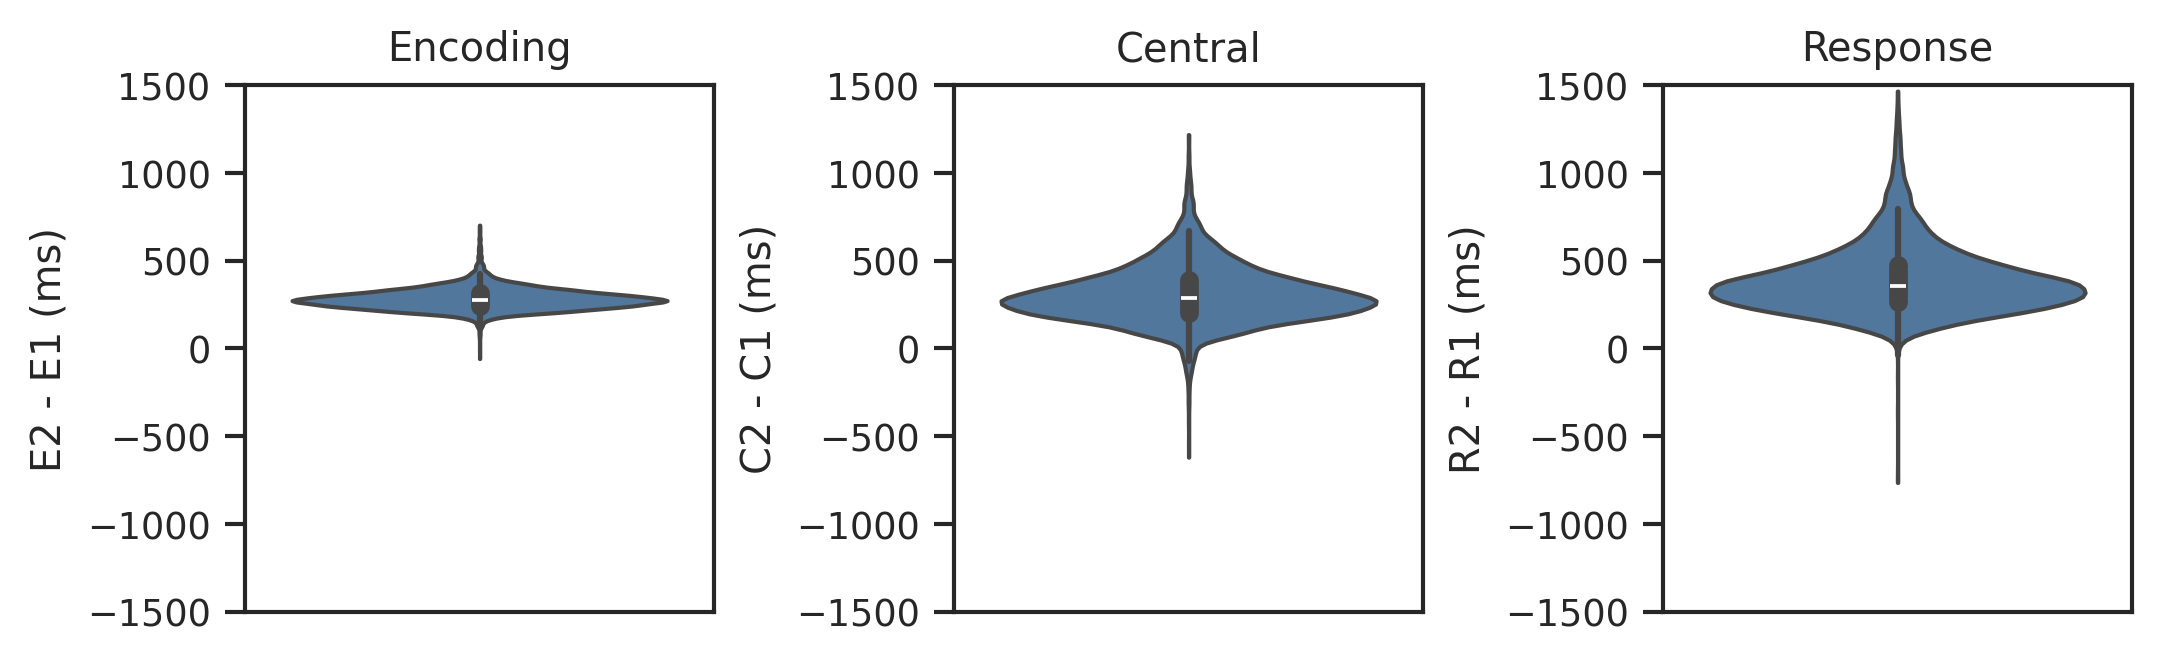

In [11]:
# Filter for short SOA condition only
# df_short = df_no_val[df_no_val["condition"] == "short"].copy()
df = determine_order_cmb(Path("files/cmb_peaks.csv"))
df_short = df[df["condition"] == "short"].copy()

# Calculate inter-event intervals (t2 - t1)
df_short["t2_1_minus_t1_1"] = ((df_short["t2_1_pred"] - df_short["t1_1_pred"]) / 250) * 1000
df_short["t2_2_minus_t1_2"] = ((df_short["t2_2_pred"] - df_short["t1_2_pred"]) / 250) * 1000
df_short["t2_3_minus_t1_3"] = ((df_short["t2_3_pred"] - df_short["t1_3_pred"]) / 250) * 1000

import seaborn as sns
import matplotlib.pyplot as plt
set_seaborn_style()
fig, ax = plt.subplots(1, 3, figsize=(7.09, 2.1), dpi=300, constrained_layout=True)

# Create violin plots for short SOA condition
sns.violinplot(data=df_short, y="t2_1_minus_t1_1", ax=ax[0], cut=0)
sns.violinplot(data=df_short, y="t2_2_minus_t1_2", ax=ax[1], cut=0)
sns.violinplot(data=df_short, y="t2_3_minus_t1_3", ax=ax[2], cut=0)

ax[0].set_ylabel("E2 - E1 (ms)")
ax[1].set_ylabel("C2 - C1 (ms)")
ax[2].set_ylabel("R2 - R1 (ms)")
ax[0].set_title("Encoding")
ax[1].set_title("Central")
ax[2].set_title("Response")
ax[0].set_ylim(-1500, 1500)
ax[1].set_ylim(-1500, 1500)
ax[2].set_ylim(-1500, 1500)

# Remove x-axis labels since we only have one condition
for a in ax:
    a.set_xlabel("")
    a.set_xticks([])

plt.show()

# New Analysis

### Sampling distributions

In [2]:
pred_ds = xr.load_dataset("files/all_pred.nc")

In [3]:
# Filter out validation participants from long condition (keep all short, keep non-val long)
mask = ~((pred_ds['condition'] == "long") & pred_ds['participant'].isin(splits[0]))
pred_ds_no_val = pred_ds.where(mask, drop=True)

In [4]:
pred_ds_t1 = pred_ds_no_val.where(pred_ds_no_val['task'] == "prp1/t1", drop=True)
pred_ds_t2 = pred_ds_no_val.where(pred_ds_no_val['task'] == "prp1/t2", drop=True)

In [14]:
pred_ds_t1

<xarray.Dataset> Size: 151MB
Dimensions:              (trial_x_participant: 14196, sample: 437, label: 6)
Coordinates: (12/16)
  * trial_x_participant  (trial_x_participant) int64 114kB 6 9 ... 46793 46795
  * sample               (sample) int64 3kB 0 1 2 3 4 5 ... 432 433 434 435 436
  * label                (label) <U4 96B 't1_1' 't1_2' 't1_3' ... 't2_2' 't2_3'
    condition            (trial_x_participant) <U5 284kB 'short' ... 'long'
    epoch                (trial_x_participant) float64 114kB 473.0 ... 846.0
    participant          (trial_x_participant) <U4 227kB 'VP19' ... 'VP10'
    ...                   ...
    task                 (trial_x_participant) <U7 397kB 'prp1/t1' ... 'prp1/t1'
    response_modality    (trial_x_participant) <U1 57kB '2' '3' '3' ... '1' '2'
    stim_code            (trial_x_participant) <U4 227kB 'c211' ... 'c231'
    block_idx            (trial_x_participant) float64 114kB 5.0 11.0 ... 9.0
    batch_idx            (trial_x_participant) int64 114kB 0 0 0 ... 365 365 365
    sample_idx           (trial_x_participant) int64 114kB 6 9 14 ... 72 73 75
Data variables:
    predictions          (trial_x_participant, sample, label) float32 149MB 1...

In [5]:
import numpy as np
from tqdm import tqdm

SFREQ = 250
long_interval_samples = int(round(1.2 * SFREQ))

t1_preds = pred_ds_t1["predictions"].values            # (N, T1, C)
t1_part  = pred_ds_t1["participant"].values            # (N,)
t1_epoch = pred_ds_t1["epoch"].values                  # (N,)
t1_intvl = pred_ds_t1["interval"].values               # (N,)

t2_preds = pred_ds_t2["predictions"].values            # (M, T2, C)
t2_part  = pred_ds_t2["participant"].values            # (M,)
t2_epoch = pred_ds_t2["epoch"].values                  # (M,)

N, T1, C = t1_preds.shape
T = T1 + long_interval_samples # Create bigger array to accomodate shifted T2

combined = np.zeros((N, T, C), dtype=t1_preds.dtype)

# If there can be duplicates, we can store a list; assuming unique is fastest.
t2_index = {}
for j in range(len(t2_part)):
    t2_index[(str(t2_part[j]), str(t2_epoch[j]))] = j

T2 = t2_preds.shape[1]

combined[:, :T1, :] = t1_preds

for i in tqdm(range(len(pred_ds_t1.trial_x_participant))):
    shift = int(round(t1_intvl[i] * SFREQ))
    j = t2_index.get((str(t1_part[i]), str(t1_epoch[i])))
    if j is None:
        continue

    end = min(T, shift + T2)
    n_write = end - shift
    combined[i, shift:end, 3:] = t2_preds[j, :n_write, 3:]

pred_ds_t1 = pred_ds_t1.reindex(sample=np.arange(T))
pred_ds_t1["predictions"] = (("trial_x_participant", "sample", "label"), combined)


100%|██████████| 14196/14196 [00:00<00:00, 120537.64it/s]


### Probabilistic sampling from distributions

In [6]:
from collections import Counter
import numpy as np
import pandas as pd

# Configuration
n_samples_per_trial = 1000  # Number of samples to draw per trial

# Get data from pred_ds_t1
predictions = pred_ds_t1['predictions'].values  # (n_trials, n_timepoints, n_events)
participants = pred_ds_t1['participant'].values
epochs = pred_ds_t1['epoch'].values
rts = pred_ds_t1['rt'].values
corrects = pred_ds_t1['correct'].values
conditions = pred_ds_t1['condition'].values

n_trials, n_timepoints, n_events = predictions.shape

# Storage for trial-level posterior probabilities
trial_posteriors = []

print(f"Processing {n_trials} trials with {n_samples_per_trial} samples each...")

# Process each trial
for trial_idx in tqdm(range(n_trials)):
    # Get trial metadata
    part = str(participants[trial_idx])
    epoch_val = epochs[trial_idx]
    rt_t1 = rts[trial_idx]
    correct_t1 = corrects[trial_idx]
    condition = conditions[trial_idx]
    
    # Get probability distributions for this trial
    probs = predictions[trial_idx]  # (n_timepoints, n_events)
    
    # Sample n_samples_per_trial times
    sampled_sequences = []
    
    for _ in range(n_samples_per_trial):
        peak_times = []
        for event_idx in range(n_events):
            event_probs = probs[:, event_idx]
            total = event_probs.sum()
            event_probs = event_probs / total
            
            # Choose random timepoint weighted by predicted probabilities for this event
            sampled_time = np.random.choice(len(event_probs), p=event_probs)
            peak_times.append(sampled_time)
        
        # Determine sequence order (argsort of peak times)
        sequence = tuple(np.argsort(peak_times))
        sampled_sequences.append(sequence)
    
    # Count occurrences of each canonical sequence for this trial
    sequence_counts = Counter(sampled_sequences)
    
    # Calculate posterior probabilities for canonical sequences (A-F)
    posterior_probs = {}
    for i, canonical_seq in enumerate(orders):
        seq_label = chr(65 + i)  # A, B, C, D, E, F
        count = sequence_counts.get(canonical_seq, 0)
        posterior_probs[f'prob_{seq_label}'] = count / n_samples_per_trial
    
    # Store trial data with posterior probabilities
    trial_data = {
        'participant': part,
        'epoch': epoch_val,
        'condition': condition,
        'rt_t1': rt_t1,
        'correct_t1': correct_t1,
        **posterior_probs
    }
    trial_posteriors.append(trial_data)

# Convert to DataFrame
posterior_df = pd.DataFrame(trial_posteriors)

print(f"\nCompleted sampling. Processed {len(posterior_df)} trials.")
print(f"\nFirst few rows:")
print(posterior_df.head())

Processing 14196 trials with 1000 samples each...


  0%|          | 0/14196 [00:00<?, ?it/s]

100%|██████████| 14196/14196 [38:02<00:00,  6.22it/s]


Completed sampling. Processed 14196 trials.

First few rows:
  participant   epoch condition     rt_t1  correct_t1  prob_A  prob_B  prob_C  \
0        VP19   473.0     short  0.632812         1.0   0.034   0.464   0.208   
1        VP19  1139.0     short  0.892578         1.0   0.014   0.329   0.404   
2        VP19   850.0     short  0.703125         1.0   0.002   0.207   0.465   
3         VP8  1061.0     short  0.578125         1.0   0.005   0.381   0.189   
4         VP9  1258.0     short  0.654297         1.0   0.004   0.182   0.281   

   prob_D  prob_E  prob_F  
0   0.158   0.060   0.007  
1   0.050   0.038   0.036  
2   0.075   0.127   0.044  
3   0.199   0.087   0.032  
4   0.172   0.179   0.048  


In [7]:
posterior_df.to_csv("files/trial_posteriors.csv", index=False)

In [5]:
posterior_df = pd.read_csv("files/trial_posteriors.csv")
results_df = pd.read_csv("files/behavior_plot_results.csv")

In [6]:
posterior_df

,participant,epoch,condition,rt_t1,correct_t1,prob_A,prob_B,prob_C,prob_D,prob_E,prob_F
0,VP19,473.0,short,0.632812,1.0,0.034,0.464,0.208,0.158,0.060,0.007
1,VP19,1139.0,short,0.892578,1.0,0.014,0.329,0.404,0.050,0.038,0.036
2,VP19,850.0,short,0.703125,1.0,0.002,0.207,0.465,0.075,0.127,0.044
3,VP8,1061.0,short,0.578125,1.0,0.005,0.381,0.189,0.199,0.087,0.032
4,VP9,1258.0,short,0.654297,1.0,0.004,0.182,0.281,0.172,0.179,0.048
...,...,...,...,...,...,...,...,...,...,...,...
14191,VP9,724.0,short,0.345703,1.0,0.664,0.113,0.001,0.000,0.000,0.000
14192,VP9,1111.0,short,0.474609,1.0,0.085,0.521,0.123,0.133,0.024,0.006
14193,VP14,940.0,short,0.693359,1.0,0.010,0.053,0.344,0.072,0.275,0.135
14194,VP14,1123.0,short,0.416016,1.0,0.789,0.071,0.003,0.000,0.000,0.000


In [7]:
results_df

,sequence,rt_mean,rt_se,rt_lo,rt_hi,logit,logit_se,prob,prob_lo,prob_hi
0,A,0.440089,0.016799,0.407163,0.473015,1.754741,0.153618,0.852550,0.810560,0.886535
1,B,0.537740,0.016668,0.505071,0.570408,2.297406,0.150710,0.908662,0.881009,0.930396
2,C,0.627947,0.017052,0.594526,0.661367,2.425479,0.175098,0.918750,0.889170,0.940959
3,D,0.650447,0.017606,0.615939,0.684955,2.764064,0.227146,0.940703,0.910427,0.961181
4,E,0.761514,0.018249,0.725746,0.797281,2.643930,0.226237,0.933636,0.900296,0.956368
5,F,0.818544,0.021508,0.776389,0.860699,2.543771,0.323634,0.927154,0.870958,0.960001


In [26]:
def plot_sequence_bargraph(posterior_df, ax, labels):
    """Plot sequence proportions using posterior probabilities."""
    set_seaborn_style()
    
    # Melt posterior_df to long format
    prob_cols = [f'prob_{label}' for label in labels]
    id_cols = ['participant', 'condition']
    
    df_long = posterior_df.melt(
        id_vars=id_cols, 
        value_vars=prob_cols,
        var_name='sequence',
        value_name='posterior_prob'
    )
    
    # Extract sequence label (A, B, C, etc.)
    df_long['sequence'] = df_long['sequence'].str.replace('prob_', '')
    
    # Map to order_idx
    seq_to_idx = {label: idx for idx, label in enumerate(labels)}
    df_long['order_idx'] = df_long['sequence'].map(seq_to_idx)
    
    # Calculate posterior-weighted proportions per participant and condition
    participant_props = (
        df_long.groupby(['participant', 'condition', 'order_idx'])['posterior_prob']
        .sum()
        .reset_index()
    )
    
    # Convert to percentages
    totals = (
        participant_props.groupby(['participant', 'condition'], as_index=False)['posterior_prob']
        .sum()
        .rename(columns={'posterior_prob': 'total'})
    )
    participant_props = participant_props.merge(totals, on=['participant', 'condition'])
    participant_props['prop'] = (participant_props['posterior_prob'] / participant_props['total']) * 100
    
    # Keep plotting order stable
    x_order = sorted(participant_props['order_idx'].unique())
    hue_order = sorted(participant_props['condition'].unique())
    
    # Draw bars
    g = sns.barplot(
        data=participant_props, x='order_idx', y='prop',
        hue='condition', ax=ax,
        order=x_order, hue_order=hue_order,
        estimator='mean',
        errorbar=('ci', 95),
        err_kws={"color": "black", "linewidth": 1},
        n_boot=5000,
        palette=["#cccccc"] * len(hue_order),
    )
    
    # Create a mapping of which combinations actually exist in the data
    existing_combos = set(participant_props[['order_idx', 'condition']].drop_duplicates().itertuples(index=False, name=None))
    
    # Recolor bars by sequence and apply hatching
    # Seaborn creates patches grouped by hue first: all 'long' bars, then all 'short' bars
    seq_palette = sns.color_palette()[5:11]
    patch_idx = 0
    for cond in hue_order:
        for x in x_order:
            if (x, cond) in existing_combos:
                g.patches[patch_idx].set_facecolor(seq_palette[x])
                if cond == 'long':
                    g.patches[patch_idx].set_hatch('//')
                patch_idx += 1
    
    # Legend
    if ax.legend_:
        ax.legend_.remove()
    handles = [
        Patch(facecolor="0.85", edgecolor="black", hatch="//"),  # long condition
        Patch(facecolor="0.85", edgecolor="black", hatch="")      # short condition
    ]
    ax.legend(handles, hue_order, title="Condition")
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_xlabel("Sequence")
    ax.set_ylabel("Trials (%)")
    ax.set_ylim(0, 100)

def plot_rt_bargraph(results_df, ax, labels):
    """Plot RT bargraph using results_df."""
    set_seaborn_style()
    
    # Filter for available sequences
    df = results_df[results_df['sequence'].isin(labels)].copy()
    df['sequence_idx'] = df['sequence'].map({label: idx for idx, label in enumerate(labels)})
    df = df.sort_values('sequence_idx')
    
    sns.barplot(
        data=df, x='sequence', y='rt_mean', 
        errorbar=None, ax=ax, 
        hue='sequence', legend=False,
        palette=sns.color_palette()[5:11]
    )
    
    ax.errorbar(
        x=np.arange(len(df)),
        y=df['rt_mean'],
        yerr=[df['rt_mean'] - df['rt_lo'], df['rt_hi'] - df['rt_mean']],
        fmt="none",
        ecolor="black",
        capsize=0
    )
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_xlabel("Sequence")
    ax.set_ylabel("Task 1 RT (in s)")
    ax.set_ylim(0, 1.0)

def plot_performance_bargraph(results_df, ax, labels):
    """Plot performance bargraph using results_df."""
    set_seaborn_style()
    
    # Filter for available sequences
    df = results_df[results_df['sequence'].isin(labels)].copy()
    df['sequence_idx'] = df['sequence'].map({label: idx for idx, label in enumerate(labels)})
    df = df.sort_values('sequence_idx')
    
    sns.barplot(
        data=df, x='sequence', y='prob', 
        errorbar=None, ax=ax, 
        hue='sequence', legend=False,
        palette=sns.color_palette()[5:11]
    )
    
    ax.errorbar(
        x=np.arange(len(df)),
        y=df['prob'],
        yerr=[df['prob'] - df['prob_lo'], df['prob_hi'] - df['prob']],
        fmt="none",
        ecolor="black",
        capsize=0
    )
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_xlabel("Sequence")
    ax.set_ylabel("Task 1 Accuracy")
    ax.set_ylim(0.6, 1.0)

def plot_sequences_per_participant(posterior_df, labels, ax):
    """Plot sequences per participant weighted by posterior probabilities."""
    set_seaborn_style()
    
    # Filter for short condition
    df = posterior_df[posterior_df['condition'] == 'short'].copy()
    
    # Melt to long format
    prob_cols = [f'prob_{label}' for label in labels]
    df_long = df.melt(
        id_vars=['participant'],
        value_vars=prob_cols,
        var_name='sequence',
        value_name='posterior_prob'
    )
    
    # Extract sequence label and map to index
    df_long['sequence'] = df_long['sequence'].str.replace('prob_', '')
    seq_to_idx = {label: idx for idx, label in enumerate(labels)}
    df_long['order_idx'] = df_long['sequence'].map(seq_to_idx)
    
    # Sum posterior probabilities per participant and sequence
    counts = (
        df_long.groupby(['participant', 'order_idx'])['posterior_prob']
        .sum()
        .unstack(fill_value=0)
    )
    
    # Sort by participant ID
    counts.index = counts.index.str.replace('VP', '').astype(int)
    counts = counts.sort_index()
    
    # Convert to percentages
    counts = counts.div(counts.sum(axis=1), axis=0) * 100
    
    # Reverse column order for stacking
    counts = counts[counts.columns[::-1]]
    
    # Define colors
    desat_hex = sns.color_palette(
        sns.color_palette()[5:11][::-1], desat=0.8
    ).as_hex()
    
    # Plot as stacked bar chart
    counts.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        width=0.9,
        color=desat_hex,
    )
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_xlabel('Participant')
    ax.set_ylabel('Trials (%)')
    ax.set_ylim(0, 100)

In [27]:
def plot_all(posterior_df, results_df):
    sequence_labels = ["A","B","C","D","E","F"]
    set_seaborn_style()
    fig = plt.figure(figsize=(7.09, 4.2), dpi=300, constrained_layout=True)
    gs  = gridspec.GridSpec(
        2, 9, figure=fig,
        width_ratios=[1,1,1, 1,1,1, 1,1,1], height_ratios=[1,1]
    )

    ax_a = fig.add_subplot(gs[0, 0:3])
    plot_sequence_bargraph(posterior_df, ax_a, sequence_labels)

    ax_b = fig.add_subplot(gs[0, 3:6])
    plot_rt_bargraph(results_df, ax_b, sequence_labels)

    ax_c = fig.add_subplot(gs[0, 6:9])
    plot_performance_bargraph(results_df, ax_c, sequence_labels)

    ax_d = fig.add_subplot(gs[1, 0:8])
    plot_sequences_per_participant(posterior_df, sequence_labels, ax_d)
    
    handles, _ = ax_d.get_legend_handles_labels()
    ax_d.legend().remove()
    fig.legend(handles[::-1], sequence_labels, title="Sequence",
               loc="center left", bbox_to_anchor=(0.885, 0.3))
    
    fig.text(0.005, 0.98, "a)", fontweight="bold")
    fig.text(0.35, 0.98, "b)", fontweight="bold")
    fig.text(0.69, 0.98, "c)", fontweight="bold")
    fig.text(0.005, 0.48, "d)", fontweight="bold")
    plt.savefig("../img/sequences_result_new.pdf", transparent=True, bbox_inches="tight")
    plt.show()

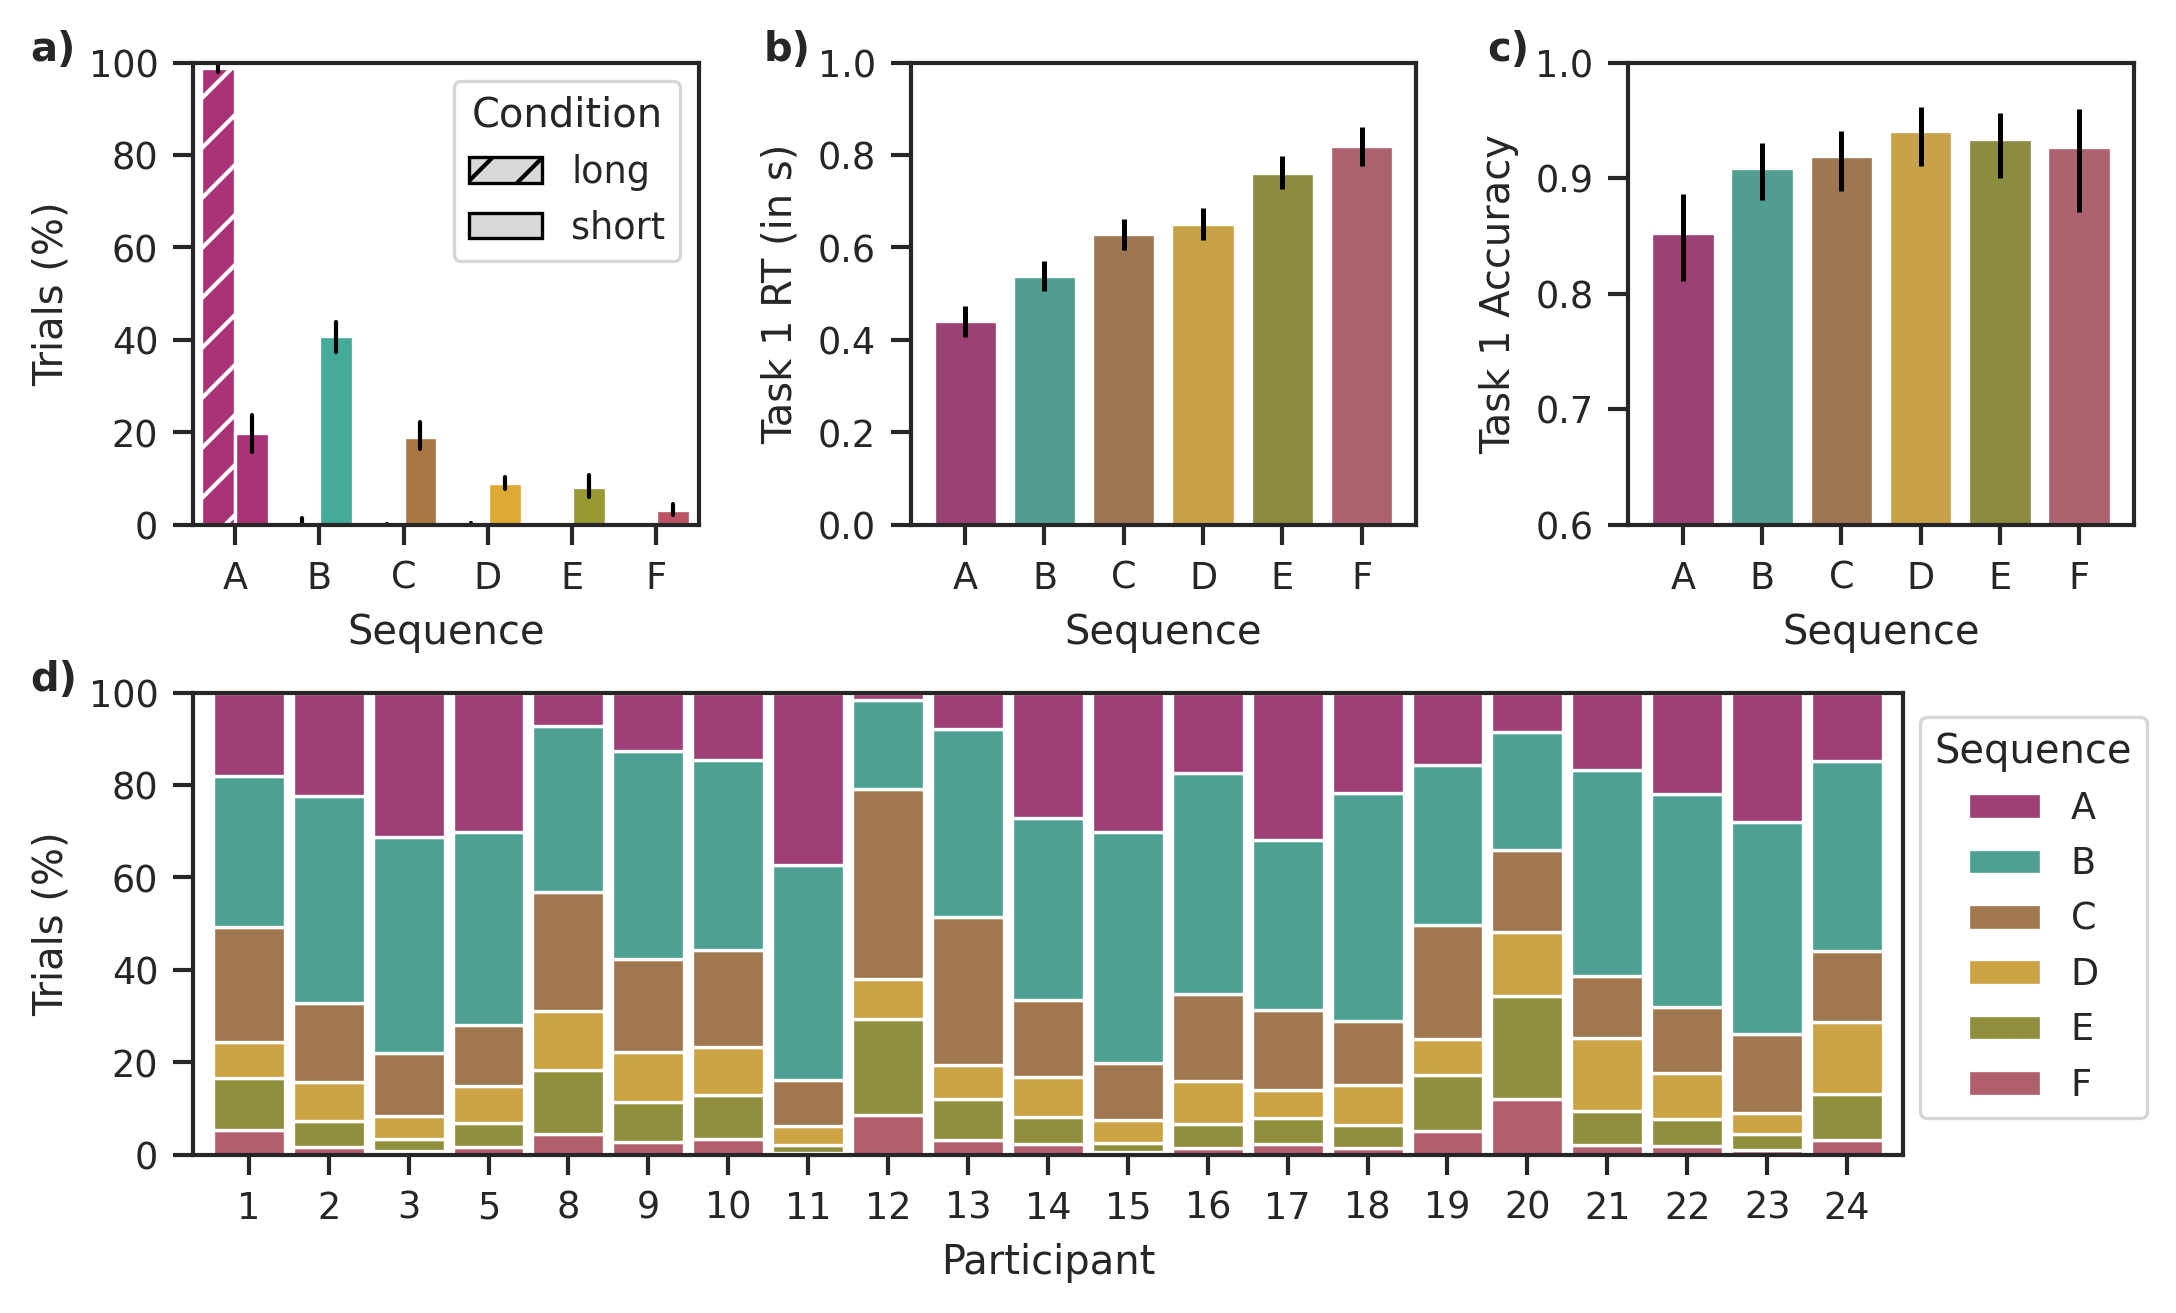

In [28]:
plot_all(posterior_df, results_df)